<h1 align="center">All relevant feature selection</h1>
<h2 align="center"> Classification - Leshy (Boruta evolution), BoostAGroota (BoostARoota evolution), GrootCV (new) </h2>
<p style="text-align:center">
   Human Bender<br>
</p>

<div align="center">
    <img border="0" src="bender_hex_mini.png" width="100px" align="center" />
</div>




<h2 style="color:#deab02;">1 - Configuration, Loading the packages, data and utilities definition </h2>
 

First let's set the libraries, general settings and define some functions (in the notebook for convenience, will be moved in a library during a later stage).

## Packages

In [1]:
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:95% !important; }</style>"))

from sklearn.datasets import fetch_openml
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import fetch_openml
from sklearn.inspection import permutation_importance
import catboost
from catboost import CatBoostRegressor, CatBoostClassifier
from boruta import BorutaPy as bp
from sklearn.datasets import load_boston, load_diabetes, load_breast_cancer
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import gc
import shap
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
from xgboost import XGBRegressor, XGBClassifier
from catboost import CatBoostRegressor, CatBoostClassifier
from sys import getsizeof, path
import arfs
import arfs.featselect as arfsfs
import arfs.allrelevant as arfsgroot
from arfs.utils import LightForestClassifier, LightForestRegressor
from arfs.utils import highlight_tick, compare_varimp
from arfs.utils import load_data, sklearn_pimp_bench
plt.style.use('fivethirtyeight')
rng = np.random.RandomState(seed=42)

import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

In [3]:
gc.enable()
gc.collect()

26

<h2 style="color:#deab02;"> Simple Usage </h2>
In the following examples, I'll use a classical data set to which I added random predictors (numerical and categorical) and a genuine but noisy artificial predictor (correlated to the target). An All Relveant FS methods should discard them.
In the unit tests, you'll find examples using artifical data with genuine (correlated and non-linear) predictors and with some random/noise columns.


In [4]:
titanic = load_data(name='Titanic')
X, y = titanic.data, titanic.target

In [5]:
X.dtypes

pclass          object
sex             object
embarked        object
random_cat      object
is_alone        object
title           object
age            float64
family_size    float64
fare           float64
random_num     float64
dtype: object

In [6]:
X.head()

,pclass,sex,embarked,random_cat,is_alone,title,age,family_size,fare,random_num
0,1.0,female,S,Thanos,1,Mrs,29.0000,0.0,211.3375,0.496714
1,1.0,male,S,Morty,0,Master,0.9167,3.0,151.5500,-0.138264
2,1.0,female,S,Bender,0,Mrs,2.0000,3.0,151.5500,0.647689
3,1.0,male,S,Cartman,0,Mr,30.0000,3.0,151.5500,1.523030
4,1.0,female,S,Cartman,0,Mrs,25.0000,3.0,151.5500,-0.234153


## Leshy

In [7]:
# Let's use lightgbm as booster, see below for using more models
model = LGBMClassifier(random_state=42, verbose=-1)

Leshy iteration:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 9/10 [00:03<00:00,  2.78it/s]




Leshy finished running using shap var. imp.

Iteration: 	10 / 10
Confirmed: 	4
Tentative: 	0
Rejected: 	3
All relevant predictors selected in 00:00:03.25
['pclass', 'sex', 'embarked', 'fare']


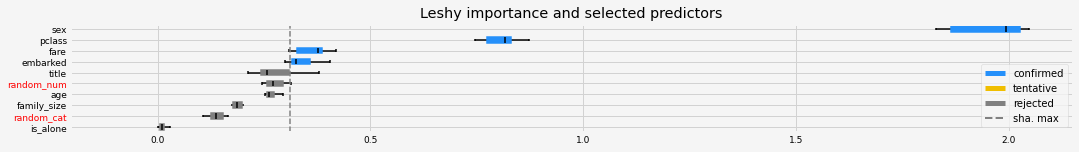

Wall time: 3.51 s


In [8]:
%%time
# Leshy
feat_selector = arfsgroot.Leshy(model, n_estimators = 100, verbose= 1, max_iter= 10, random_state=42, importance='shap')
feat_selector.fit(X, y, sample_weight=None)
print(feat_selector.support_names_)
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match='random')
fig = highlight_tick(figure=fig, str_match='genuine', color='green')
plt.show()

In [9]:
feat_selector.tag_df

,predictor,Boruta,Boruta_weak_incl
0,pclass,1,1
1,sex,1,1
2,embarked,1,1
3,random_cat,0,0
4,is_alone,0,0
5,title,0,0
6,age,0,0
7,family_size,0,0
8,fare,1,1
9,random_num,0,0


## BoostAGroota

BoostaGRoota round:  10%|█████████████▎                                                                                                                       | 1/10 [00:05<00:51,  5.70s/it]

0    pclass
1       sex
2       age
3      fare
Name: feature, dtype: object


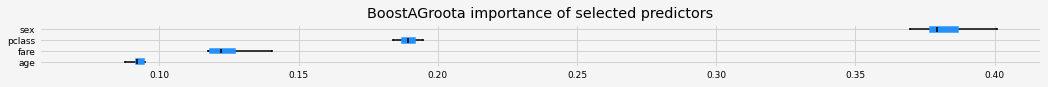

Wall time: 5.87 s


In [10]:
%%time
# BoostAGroota
feat_selector = arfsgroot.BoostAGroota(est=model, cutoff=1, iters=10, max_rounds=10, delta=0.1, importance='shap')
feat_selector.fit(X, y, sample_weight=None)
print(feat_selector.support_names_)
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match='random')
fig = highlight_tick(figure=fig, str_match='genuine', color='green')
plt.show()

## GrootCV

Repeated k-fold: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:03<00:00,  7.20it/s]


0       age
2      fare
4    pclass
5       sex
9     title
Name: feature, dtype: object


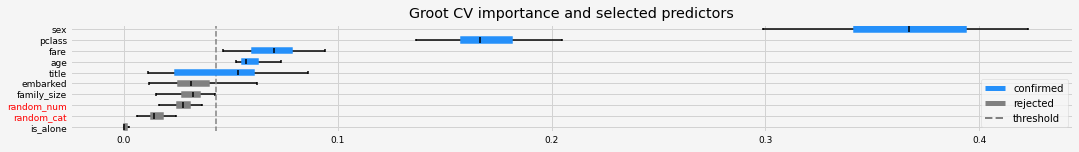

Wall time: 3.74 s


In [11]:
%%time
# GrootCV
feat_selector = arfsgroot.GrootCV(objective='binary', cutoff = 1, n_folds=5, n_iter=5, silent=True)
feat_selector.fit(X, y, sample_weight=None)
print(feat_selector.support_names_)
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match='random')
fig = highlight_tick(figure=fig, str_match='genuine', color='green')
plt.show()

<h2 style="color:#deab02;"> Testing and comparing Leshy, GrootCV and BoostAGroota </h2>

In the following examples, I'll use different models which are scikit-learn compatible and then one can compare the different ARFS methods with different models and the different feature importance.

==================== Benchmarking using sklearn permutation importance ====================


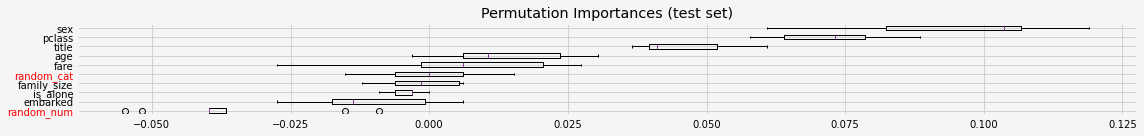

Wall time: 2.76 s


In [12]:
%%time

# Benchmark with scikit-learn permutation importance
print('=' * 20 + ' Benchmarking using sklearn permutation importance ' + '=' * 20)
fig = sklearn_pimp_bench(model, X, y, task='classification', sample_weight=None)

# Testing Leshy

Leshy iteration:   0%|                                                                                                                                                | 0/10 [00:00<?, ?it/s]

==================== Leshy - testing:        RandomForestClassifier(n_jobs=4, oob_score=True) for var.imp: shap            ====================


Leshy iteration:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 9/10 [00:03<00:00,  2.90it/s]




Leshy finished running using shap var. imp.

Iteration: 	10 / 10
Confirmed: 	3
Tentative: 	1
Rejected: 	3
All relevant predictors selected in 00:00:03.11
['pclass', 'sex', 'fare']


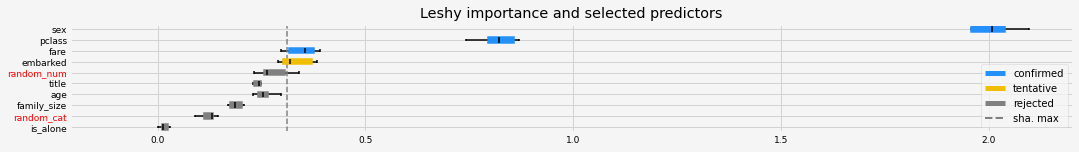

Leshy iteration:   0%|                                                                                                                                                | 0/10 [00:00<?, ?it/s]

==================== Leshy - testing:        RandomForestClassifier(n_jobs=4, oob_score=True) for var.imp: pimp            ====================


Leshy iteration:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 9/10 [00:06<00:00,  1.36it/s]




Leshy finished running using pimp var. imp.

Iteration: 	10 / 10
Confirmed: 	2
Tentative: 	2
Rejected: 	1
All relevant predictors selected in 00:00:06.64
['pclass', 'sex']


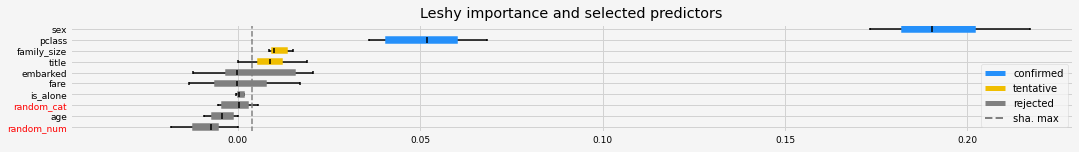

Leshy iteration:  10%|█████████████▌                                                                                                                          | 1/10 [00:00<00:01,  7.83it/s]

==================== Leshy - testing:        RandomForestClassifier(n_jobs=4, oob_score=True) for var.imp: native          ====================


Leshy iteration:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 9/10 [00:01<00:00,  7.52it/s]




Leshy finished running using native var. imp.

Iteration: 	10 / 10
Confirmed: 	1
Tentative: 	1
Rejected: 	8
All relevant predictors selected in 00:00:01.21
['fare']


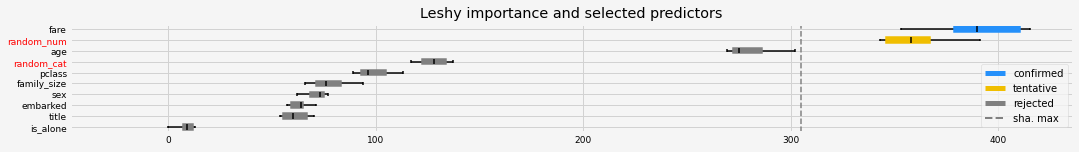

Leshy iteration:   0%|                                                                                                                                                | 0/10 [00:00<?, ?it/s]

==================== Leshy - testing: <catboost.core.CatBoostClassifier object at 0x000001ED2DD170C8> for var.imp: shap            ====================


Leshy iteration:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 9/10 [00:03<00:00,  2.90it/s]




Leshy finished running using shap var. imp.

Iteration: 	10 / 10
Confirmed: 	3
Tentative: 	1
Rejected: 	3
All relevant predictors selected in 00:00:03.11
['pclass', 'sex', 'embarked']


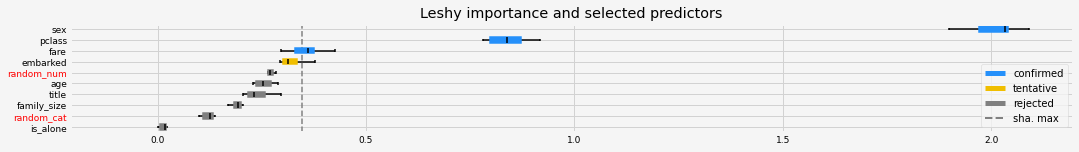

Leshy iteration:   0%|                                                                                                                                                | 0/10 [00:00<?, ?it/s]

==================== Leshy - testing: <catboost.core.CatBoostClassifier object at 0x000001ED2DD170C8> for var.imp: pimp            ====================


Leshy iteration:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 9/10 [00:04<00:00,  2.08it/s]




Leshy finished running using pimp var. imp.

Iteration: 	10 / 10
Confirmed: 	3
Tentative: 	3
Rejected: 	2
All relevant predictors selected in 00:00:04.34
['pclass', 'sex', 'title']


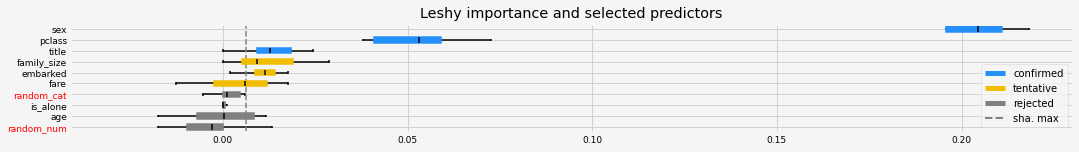

Leshy iteration:  10%|█████████████▌                                                                                                                          | 1/10 [00:00<00:01,  5.93it/s]

==================== Leshy - testing: <catboost.core.CatBoostClassifier object at 0x000001ED2DD170C8> for var.imp: native          ====================


Leshy iteration:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 9/10 [00:01<00:00,  7.01it/s]




Leshy finished running using native var. imp.

Iteration: 	10 / 10
Confirmed: 	1
Tentative: 	1
Rejected: 	8
All relevant predictors selected in 00:00:01.29
['random_num']


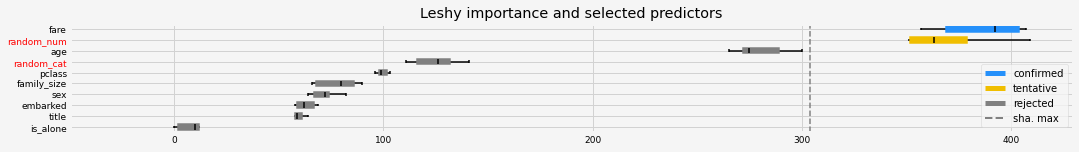

Leshy iteration:   0%|                                                                                                                                                | 0/10 [00:00<?, ?it/s]

==================== Leshy - testing: XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=42, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=0) for var.imp: shap            ====================


Leshy iteration:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 9/10 [00:03<00:00,  2.85it/s]




Leshy finished running using shap var. imp.

Iteration: 	10 / 10
Confirmed: 	3
Tentative: 	2
Rejected: 	3
All relevant predictors selected in 00:00:03.17
['pclass', 'sex', 'fare']


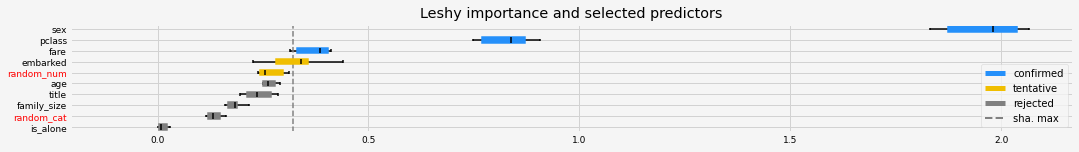

Leshy iteration:   0%|                                                                                                                                                | 0/10 [00:00<?, ?it/s]

==================== Leshy - testing: XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=42, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=0) for var.imp: pimp            ====================


Leshy iteration:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 9/10 [00:04<00:00,  2.14it/s]




Leshy finished running using pimp var. imp.

Iteration: 	10 / 10
Confirmed: 	2
Tentative: 	3
Rejected: 	2
All relevant predictors selected in 00:00:04.22
['pclass', 'sex']


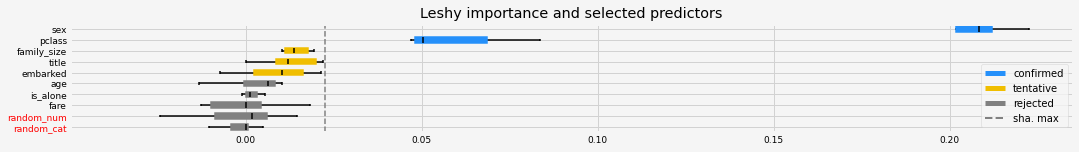

Leshy iteration:  10%|█████████████▌                                                                                                                          | 1/10 [00:00<00:00,  9.55it/s]

==================== Leshy - testing: XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=42, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=0) for var.imp: native          ====================


Leshy iteration:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 8/10 [00:01<00:00,  7.84it/s]




Leshy finished running using native var. imp.

Iteration: 	9 / 10
Confirmed: 	2
Tentative: 	0
Rejected: 	8
All relevant predictors selected in 00:00:01.03
['fare', 'random_num']


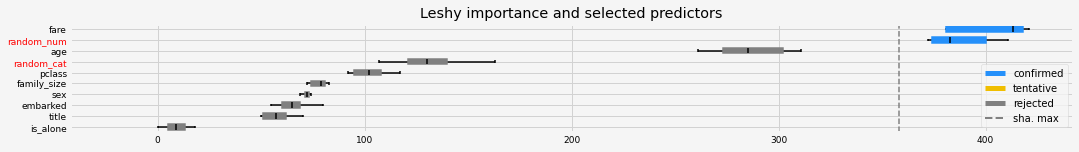

Leshy iteration:   0%|                                                                                                                                                | 0/10 [00:00<?, ?it/s]

==================== Leshy - testing:             LGBMClassifier(random_state=42, verbose=-1) for var.imp: shap            ====================


Leshy iteration:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 9/10 [00:03<00:00,  2.92it/s]




Leshy finished running using shap var. imp.

Iteration: 	10 / 10
Confirmed: 	2
Tentative: 	3
Rejected: 	3
All relevant predictors selected in 00:00:03.10
['pclass', 'sex']


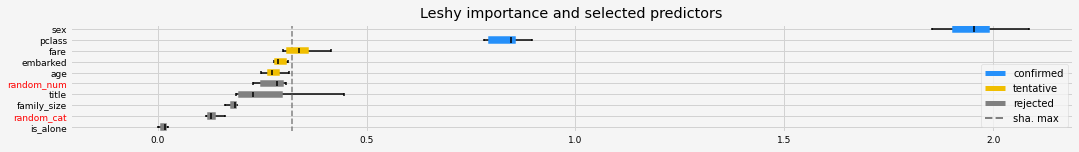

Leshy iteration:   0%|                                                                                                                                                | 0/10 [00:00<?, ?it/s]

==================== Leshy - testing:             LGBMClassifier(random_state=42, verbose=-1) for var.imp: pimp            ====================


Leshy iteration:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 9/10 [00:04<00:00,  2.16it/s]




Leshy finished running using pimp var. imp.

Iteration: 	10 / 10
Confirmed: 	2
Tentative: 	4
Rejected: 	2
All relevant predictors selected in 00:00:04.17
['pclass', 'sex']


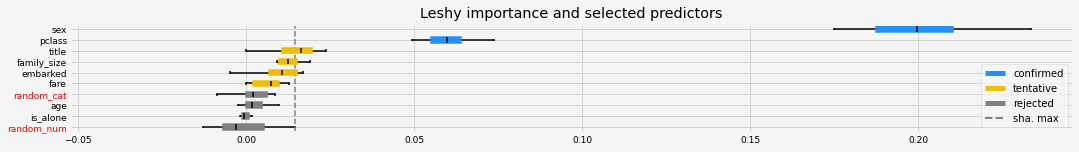

Leshy iteration:  10%|█████████████▌                                                                                                                          | 1/10 [00:00<00:00,  9.64it/s]

==================== Leshy - testing:             LGBMClassifier(random_state=42, verbose=-1) for var.imp: native          ====================


Leshy iteration:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 8/10 [00:01<00:00,  7.70it/s]




Leshy finished running using native var. imp.

Iteration: 	9 / 10
Confirmed: 	2
Tentative: 	0
Rejected: 	8
All relevant predictors selected in 00:00:01.05
['fare', 'random_num']


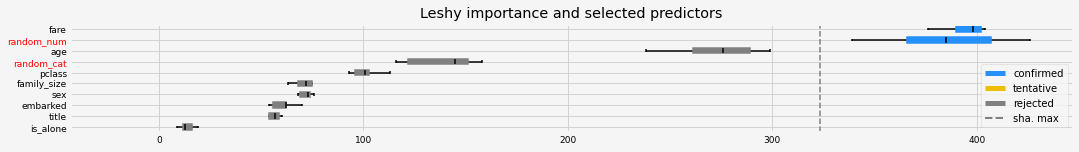

Leshy iteration:   0%|                                                                                                                                                | 0/10 [00:00<?, ?it/s]

==================== Leshy - testing: LGBMClassifier(boosting_type='rf', colsample_bytree=0.31622776601683794,
               force_col_wise=True, subsample=0.632, subsample_freq=1,
               verbose=-1) for var.imp: shap            ====================


Leshy iteration:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 9/10 [00:03<00:00,  2.82it/s]




Leshy finished running using shap var. imp.

Iteration: 	10 / 10
Confirmed: 	2
Tentative: 	2
Rejected: 	3
All relevant predictors selected in 00:00:03.20
['pclass', 'sex']


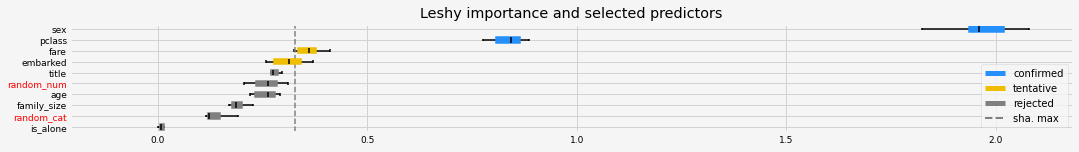

Leshy iteration:   0%|                                                                                                                                                | 0/10 [00:00<?, ?it/s]

==================== Leshy - testing: LGBMClassifier(boosting_type='rf', colsample_bytree=0.31622776601683794,
               force_col_wise=True, subsample=0.632, subsample_freq=1,
               verbose=-1) for var.imp: pimp            ====================


Leshy iteration:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 9/10 [00:04<00:00,  2.20it/s]




Leshy finished running using pimp var. imp.

Iteration: 	10 / 10
Confirmed: 	3
Tentative: 	3
Rejected: 	3
All relevant predictors selected in 00:00:04.11
['pclass', 'sex', 'title']


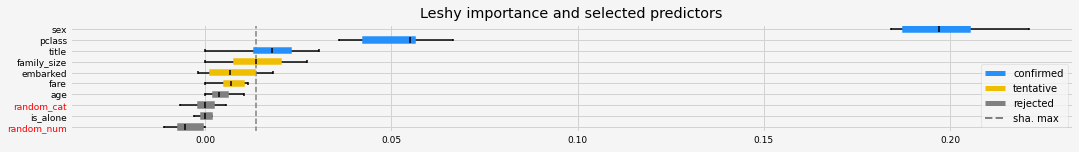

Leshy iteration:  10%|█████████████▌                                                                                                                          | 1/10 [00:00<00:01,  6.92it/s]

==================== Leshy - testing: LGBMClassifier(boosting_type='rf', colsample_bytree=0.31622776601683794,
               force_col_wise=True, subsample=0.632, subsample_freq=1,
               verbose=-1) for var.imp: native          ====================


Leshy iteration:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 9/10 [00:01<00:00,  7.99it/s]




Leshy finished running using native var. imp.

Iteration: 	10 / 10
Confirmed: 	0
Tentative: 	2
Rejected: 	8
All relevant predictors selected in 00:00:01.14
[]


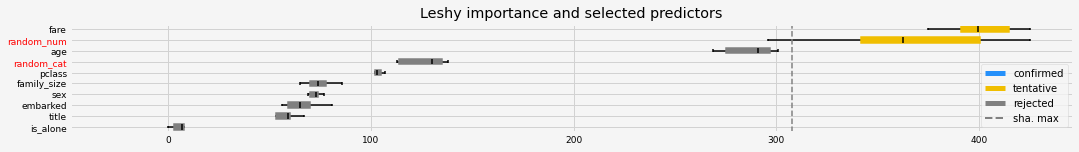

In [13]:
models = [RandomForestClassifier(n_jobs= 4, oob_score= True), 
          CatBoostClassifier(random_state=42, verbose=0), 
          XGBClassifier(random_state=42, verbosity=0), 
          LGBMClassifier(random_state=42, verbose=-1),
          LightForestClassifier(n_feat=X.shape[1])]

feat_selector = arfsgroot.Leshy(model, n_estimators = 100, verbose= 1, max_iter= 10, random_state=42)

if __name__ == '__main__':
    # classification
    titanic = load_data(name='Titanic')
    X, y = titanic.data, titanic.target
    cat_f = titanic.categorical
    # running the ARFS methods using different models
    compare_varimp(feat_selector, models, X, y, sample_weight=None)

# Testing GrootCV

Repeated k-fold: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:03<00:00,  7.87it/s]


0       age
2      fare
4    pclass
5       sex
Name: feature, dtype: object


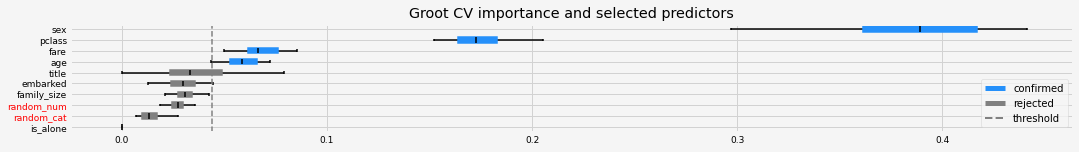

In [14]:
# Testing the changes with rnd cat. and num. predictors added to the set of genuine predictors
def testing_estimators(X, y, sample_weight=None, objective='binary'):
    feat_selector = arfsgroot.GrootCV(objective=objective, cutoff = 1, n_folds=5, n_iter=5)
    feat_selector.fit(X, y, sample_weight)
    print(feat_selector.support_names_)
    fig = feat_selector.plot_importance(n_feat_per_inch=5)

    # highlight synthetic random variable
    fig = highlight_tick(figure=fig, str_match='random')
    plt.show()
    gc.enable()
    del(feat_selector)
    gc.collect()
        

if __name__ == '__main__':
    # classification
    titanic = load_data(name='Titanic')
    X, y = titanic.data, titanic.target
    cat_f = titanic.categorical
    testing_estimators(X=X, y=y, objective='binary')

This confirms that the native (gini/gain) feature importance are biased and not the best to assess the real feature importance.

# Testing BoostAGroota

BoostaGRoota round:   0%|                                                                                                                                             | 0/10 [00:00<?, ?it/s]

==================== BoostAGroota - testing:        RandomForestClassifier(n_jobs=4, oob_score=True) for var.imp: shap            ====================


BoostaGRoota round:  10%|█████████████▎                                                                                                                       | 1/10 [00:05<00:52,  5.80s/it]

0      pclass
1         sex
2    embarked
3         age
4        fare
Name: feature, dtype: object


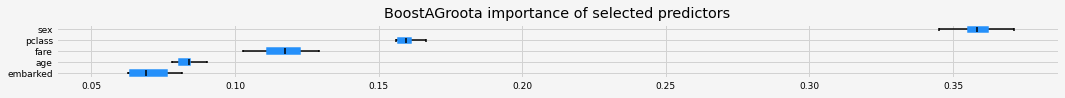

BoostaGRoota round:   0%|                                                                                                                                             | 0/10 [00:00<?, ?it/s]

==================== BoostAGroota - testing:        RandomForestClassifier(n_jobs=4, oob_score=True) for var.imp: pimp            ====================


BoostaGRoota round:  10%|█████████████▎                                                                                                                       | 1/10 [00:07<01:07,  7.47s/it]

0         pclass
1            sex
2            age
3    family_size
4           fare
Name: feature, dtype: object


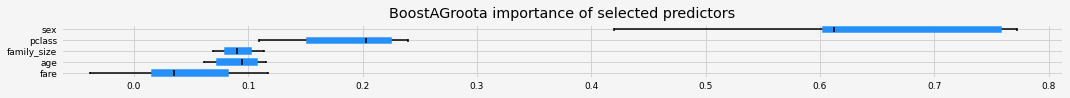

BoostaGRoota round:   0%|                                                                                                                                             | 0/10 [00:00<?, ?it/s]

==================== BoostAGroota - testing:        RandomForestClassifier(n_jobs=4, oob_score=True) for var.imp: native          ====================


BoostaGRoota round:  10%|█████████████▎                                                                                                                       | 1/10 [00:01<00:12,  1.37s/it]

0          fare
1    random_num
Name: feature, dtype: object


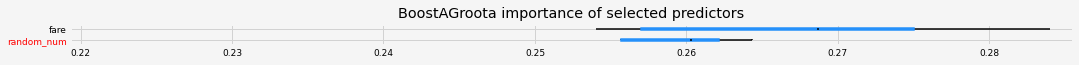

BoostaGRoota round:   0%|                                                                                                                                             | 0/10 [00:00<?, ?it/s]

==================== BoostAGroota - testing: <catboost.core.CatBoostClassifier object at 0x000001ED2F5B26C8> for var.imp: shap            ====================


BoostaGRoota round:  10%|█████████████▎                                                                                                                       | 1/10 [00:05<00:51,  5.76s/it]

0      pclass
1         sex
2    embarked
3         age
4        fare
Name: feature, dtype: object


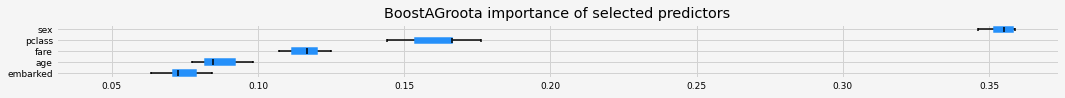

BoostaGRoota round:   0%|                                                                                                                                             | 0/10 [00:00<?, ?it/s]

==================== BoostAGroota - testing: <catboost.core.CatBoostClassifier object at 0x000001ED2F5B26C8> for var.imp: pimp            ====================


BoostaGRoota round:  20%|██████████████████████████▌                                                                                                          | 2/10 [00:10<00:43,  5.45s/it]

0         pclass
1            sex
2            age
3    family_size
4           fare
Name: feature, dtype: object


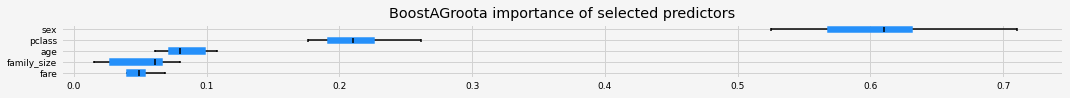

BoostaGRoota round:   0%|                                                                                                                                             | 0/10 [00:00<?, ?it/s]

==================== BoostAGroota - testing: <catboost.core.CatBoostClassifier object at 0x000001ED2F5B26C8> for var.imp: native          ====================


BoostaGRoota round:  10%|█████████████▎                                                                                                                       | 1/10 [00:01<00:13,  1.54s/it]

0          fare
1    random_num
Name: feature, dtype: object


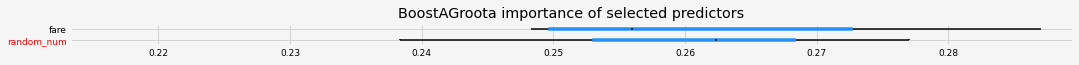

BoostaGRoota round:   0%|                                                                                                                                             | 0/10 [00:00<?, ?it/s]

==================== BoostAGroota - testing: XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=42, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=0) for var.imp: shap            ====================


BoostaGRoota round:  20%|██████████████████████████▌                                                                                                          | 2/10 [00:08<00:35,  4.45s/it]

0    pclass
1       sex
2       age
3      fare
Name: feature, dtype: object


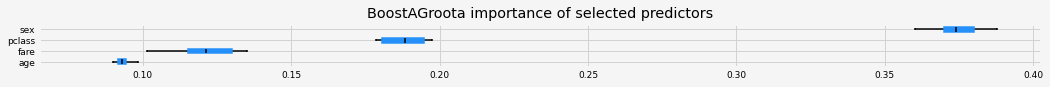

BoostaGRoota round:   0%|                                                                                                                                             | 0/10 [00:00<?, ?it/s]

==================== BoostAGroota - testing: XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=42, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=0) for var.imp: pimp            ====================


BoostaGRoota round:  10%|█████████████▎                                                                                                                       | 1/10 [00:07<01:06,  7.34s/it]

0         pclass
1            sex
2            age
3    family_size
Name: feature, dtype: object


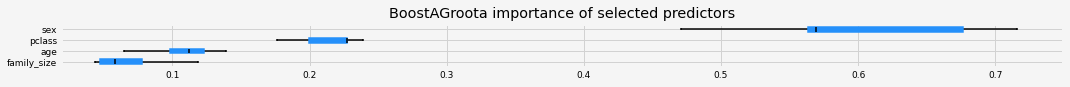

BoostaGRoota round:   0%|                                                                                                                                             | 0/10 [00:00<?, ?it/s]

==================== BoostAGroota - testing: XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=42, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=0) for var.imp: native          ====================


BoostaGRoota round:  10%|█████████████▎                                                                                                                       | 1/10 [00:01<00:12,  1.41s/it]

0          fare
1    random_num
Name: feature, dtype: object


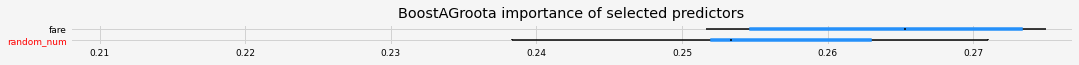

BoostaGRoota round:   0%|                                                                                                                                             | 0/10 [00:00<?, ?it/s]

==================== BoostAGroota - testing:             LGBMClassifier(random_state=42, verbose=-1) for var.imp: shap            ====================


BoostaGRoota round:  20%|██████████████████████████▌                                                                                                          | 2/10 [00:08<00:35,  4.45s/it]

0        pclass
1           sex
2      embarked
3           age
4          fare
5    random_num
Name: feature, dtype: object


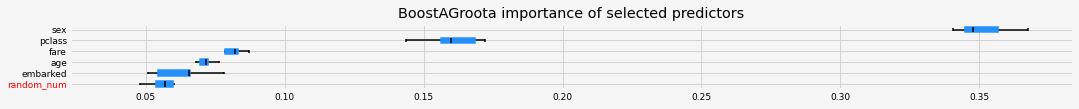

BoostaGRoota round:   0%|                                                                                                                                             | 0/10 [00:00<?, ?it/s]

==================== BoostAGroota - testing:             LGBMClassifier(random_state=42, verbose=-1) for var.imp: pimp            ====================


BoostaGRoota round:  10%|█████████████▎                                                                                                                       | 1/10 [00:08<01:12,  8.06s/it]

0         pclass
1            sex
2       embarked
3            age
4    family_size
5           fare
Name: feature, dtype: object


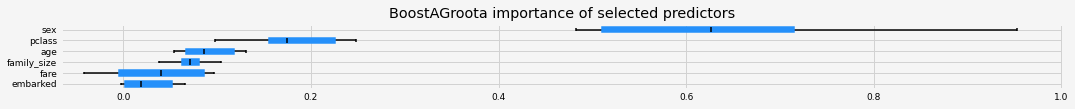

BoostaGRoota round:   0%|                                                                                                                                             | 0/10 [00:00<?, ?it/s]

==================== BoostAGroota - testing:             LGBMClassifier(random_state=42, verbose=-1) for var.imp: native          ====================


BoostaGRoota round:  10%|█████████████▎                                                                                                                       | 1/10 [00:01<00:12,  1.42s/it]

0          fare
1    random_num
Name: feature, dtype: object


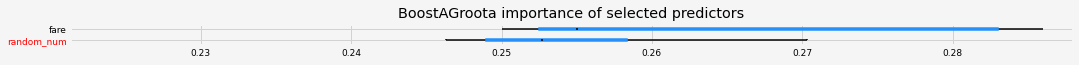

BoostaGRoota round:   0%|                                                                                                                                             | 0/10 [00:00<?, ?it/s]

==================== BoostAGroota - testing: LGBMClassifier(boosting_type='rf', colsample_bytree=0.31622776601683794,
               force_col_wise=True, subsample=0.632, subsample_freq=1,
               verbose=-1) for var.imp: shap            ====================


BoostaGRoota round:  10%|█████████████▎                                                                                                                       | 1/10 [00:05<00:51,  5.72s/it]

0      pclass
1         sex
2    embarked
3         age
4        fare
Name: feature, dtype: object


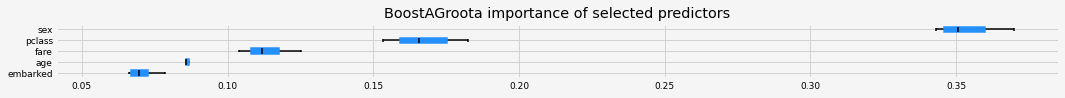

BoostaGRoota round:   0%|                                                                                                                                             | 0/10 [00:00<?, ?it/s]

==================== BoostAGroota - testing: LGBMClassifier(boosting_type='rf', colsample_bytree=0.31622776601683794,
               force_col_wise=True, subsample=0.632, subsample_freq=1,
               verbose=-1) for var.imp: pimp            ====================


BoostaGRoota round:  10%|█████████████▎                                                                                                                       | 1/10 [00:07<01:10,  7.83s/it]

0         pclass
1            sex
2            age
3    family_size
4           fare
Name: feature, dtype: object


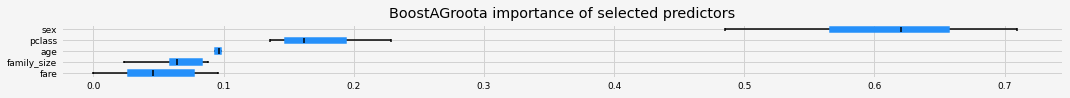

BoostaGRoota round:   0%|                                                                                                                                             | 0/10 [00:00<?, ?it/s]

==================== BoostAGroota - testing: LGBMClassifier(boosting_type='rf', colsample_bytree=0.31622776601683794,
               force_col_wise=True, subsample=0.632, subsample_freq=1,
               verbose=-1) for var.imp: native          ====================


BoostaGRoota round:  10%|█████████████▎                                                                                                                       | 1/10 [00:01<00:12,  1.39s/it]

0          fare
1    random_num
Name: feature, dtype: object


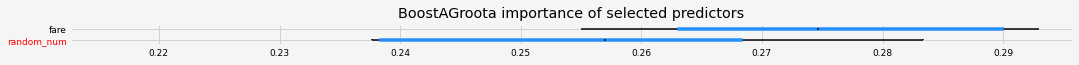

In [15]:
models = [RandomForestClassifier(n_jobs= 4, oob_score= True), 
          CatBoostClassifier(random_state=42, verbose=0), 
          XGBClassifier(random_state=42, verbosity=0), 
          LGBMClassifier(random_state=42, verbose=-1),
          LightForestClassifier(n_feat=X.shape[1])]

feat_selector = arfsgroot.BoostAGroota(est=model, cutoff=1.25, iters=10, max_rounds=10, delta=0.1)

if __name__ == '__main__':
    # classification
    titanic = load_data(name='Titanic')
    X, y = titanic.data, titanic.target
    cat_f = titanic.categorical
    # running the ARFS methods using different models
    compare_varimp(feat_selector, models, X, y, sample_weight=None)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.18it/s]


5 attributes confirmed important: ['sex', 'pclass', 'title', 'age', 'fare']
5 attributes confirmed unimportant: ['family_size', 'embarked', 'random_num', 'random_cat', 'is_alone']
0 tentative attributes remains: []


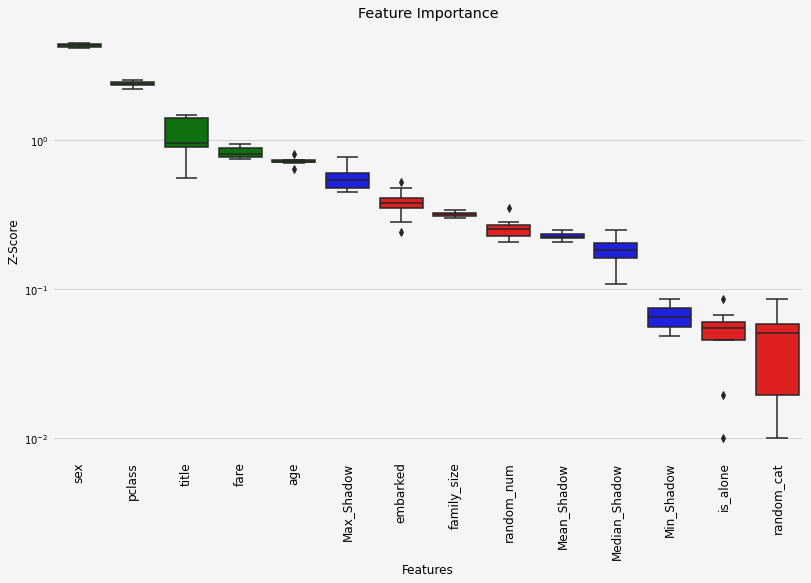

In [21]:
from BorutaShap import BorutaShap
from arfs.utils import cat_var
model = LGBMClassifier(random_state=42, verbose=-1, n_estimators=10)
df, cat_var_df, inv_mapper = cat_var(X)
Feature_Selector = BorutaShap(model=model, importance_measure='shap', classification=True)

Feature_Selector.fit(X=df, y=y, n_trials=100, random_state=0)

# Returns Boxplot of features
Feature_Selector.plot(X_size=12, figsize=(12,8), y_scale='log', which_features='all')

Leshy iteration:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 99/100 [00:03<00:00, 25.70it/s]




Leshy finished running using shap var. imp.

Iteration: 	100 / 100
Confirmed: 	5
Tentative: 	0
Rejected: 	4
All relevant predictors selected in 00:00:03.88
['pclass', 'sex', 'embarked', 'age', 'fare']


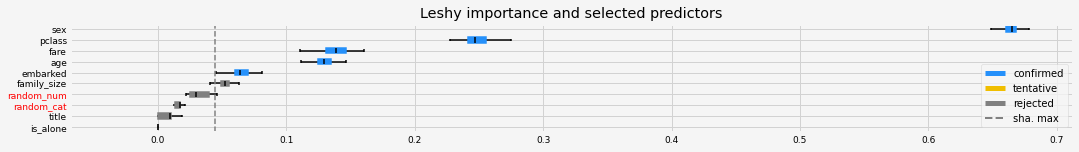

In [22]:
# Leshy
feat_selector = arfsgroot.Leshy(model, n_estimators=10, verbose=1, max_iter=100, random_state=42, importance='shap')
feat_selector.fit(df, y, sample_weight=None)
print(feat_selector.support_names_)
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match='random')
fig = highlight_tick(figure=fig, str_match='genuine', color='green')
plt.show()